# Stitching Images to Panoramic View

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

## Primeiro Caso: 2 imagens recortadas a partir de outra

Text(0.5, 1.0, 'Training image (Image to be stitched to Query image)')

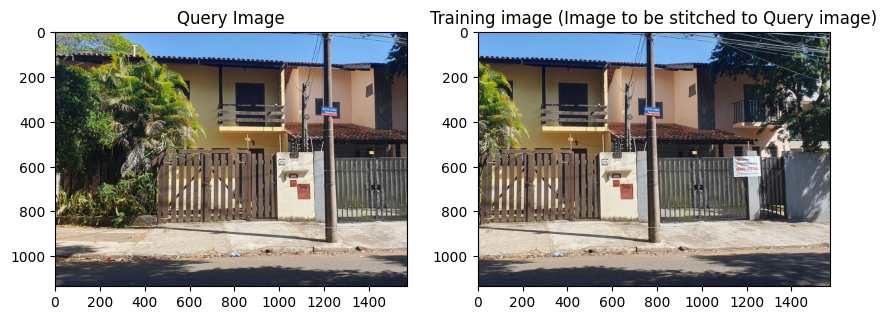

In [53]:
# Usaremos a imagem colorida apenas para visualização e a imagem cinza para processamento 
queryImg = cv2.imread('images/reduce/casa1_2.png', 1)
queryImg_gray = cv2.cvtColor(queryImg, cv2.COLOR_BGR2GRAY)
queryImg = cv2.cvtColor(queryImg, cv2.COLOR_BGR2RGB)

trainImg = cv2.imread('images/reduce/casa1_1.png', 1)
trainImg_gray = cv2.cvtColor(trainImg, cv2.COLOR_BGR2GRAY)
trainImg = cv2.cvtColor(trainImg, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(queryImg)
plt.title('Query Image')

plt.subplot(1,2,2)
plt.imshow(trainImg)
plt.title('Training image (Image to be stitched to Query image)')

### Extração e Detecção de Características

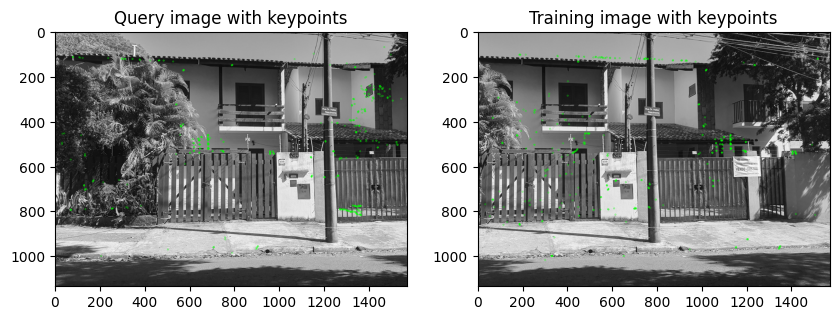

In [54]:
# Busca os pontos-chave e recursos correspondentes às imagens
descriptor = cv2.ORB_create()

kpsA, featuresA = descriptor.detectAndCompute(trainImg_gray, None)
kpsB, featuresB = descriptor.detectAndCompute(queryImg_gray, None)

# Desenha os pontos-chave obtidos nas imagens
img_kpsA = cv2.drawKeypoints(trainImg_gray ,kpsA,None,color=(0,255,0))
img_kpsB = cv2.drawKeypoints(queryImg_gray,kpsB,None,color=(0,255,0))

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(img_kpsA)
plt.title('Query image with keypoints')

plt.subplot(1,2,2)
plt.imshow(img_kpsB)
plt.title('Training image with keypoints')

plt.show()

### Correspondência de Características

Matches (Brute Force): 246


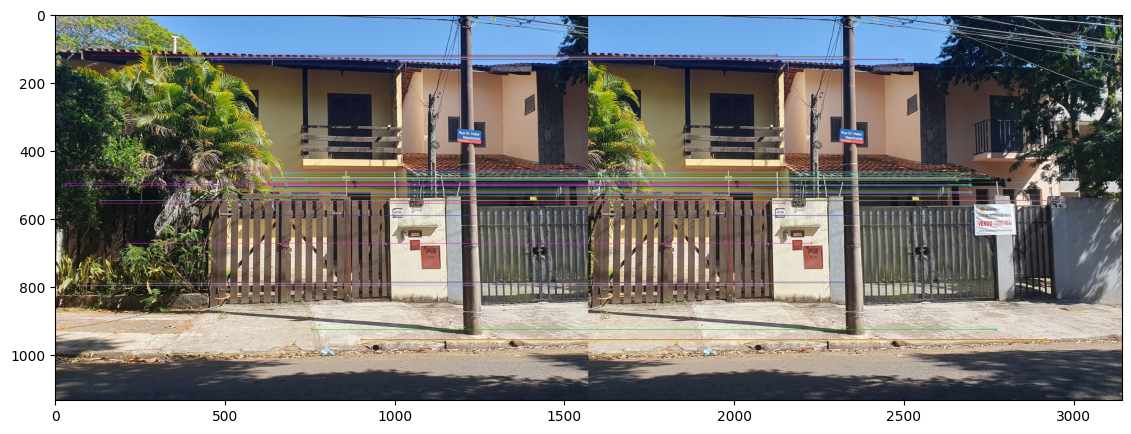

In [55]:
# Vamos encontrar os ponto chaves correspondentes nessas duas imagens

## Força Bruta (BF)
# É sugerido na documentação do Opencv usar a norma de Hamming - NORM_HAMMING - com os métodos ORB, BRISK and BRIEF
bf = cv2.BFMatcher_create(cv2.NORM_HAMMING, crossCheck=True)
best_matches = bf.match(featuresA,featuresB)
matches = sorted(best_matches, key = lambda x:x.distance)

print('Matches (Brute Force):', len(matches))

## KNN Matches
# Encontra os K maiores matches
# bf = cv2.BFMatcher_create(cv2.NORM_HAMMING, crossCheck=False)
# best_matches = bf.knnMatch(featuresA,featuresB, 2)
# matches = list(map(lambda x: x[0], best_matches))

# print('Matches (knn):', len(matches))

plt.figure(figsize=(20,5))
plt.imshow(
    cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,matches[:50],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
)

plt.show()


### Encontrando a matriz de Homografia

In [56]:
# Coordenadas do pontos-chave
kpsA = np.float32([kp.pt for kp in kpsA])
kpsB = np.float32([kp.pt for kp in kpsB])

# Índices dos pontos-chaves no descriptor
ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
ptsB = np.float32([kpsB[m.trainIdx] for m in matches])

# DOC: Finds a perspective transformation between two planes. 
(H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,4)

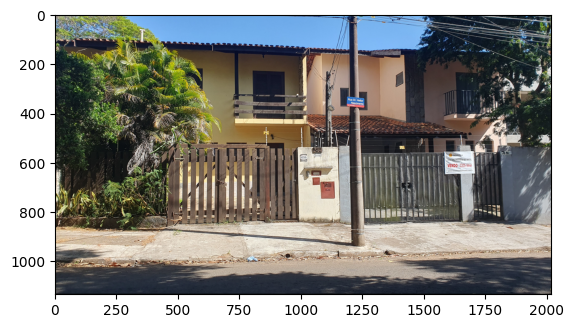

In [57]:
# Por fim, vamos gerar o resultado final
width = trainImg.shape[1] + queryImg.shape[1]
height = trainImg.shape[0] + queryImg.shape[0]

result = cv2.warpPerspective(trainImg, H, (width, height))
result[0:queryImg.shape[0], 0:queryImg.shape[1]] = queryImg

_x = np.nonzero(result.sum(0).sum(-1) == 0)[0][0]
_y = np.nonzero(result.sum(1).sum(-1) == 0)[0][0]

plt.imshow(result[:_y,:_x])
#plt.imsave('outputs/result_orb.png', result[:_y,:_x])